# kNN algorithm: development and visualization

This notebook develops a k-Nearest-Neighbors (kNN) algorithm "from scratch" in Python, that is, not using pre coded packages such as sci-kit learn. This version is a <b>brute force algorithm</b>; that is, it looks for the k nearest neighbors through exaustion of the training set. We will allow for some flexibility involving the metric chosen for the calculation and the use of a weighted or uniform prediction function. After that, we will present a series of visualizations of the algorithm using the iris dataset.  

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.spatial import distance as spdist
import warnings
warnings.filterwarnings('ignore')

# Metrics

Below we define a collection of metrics to use in our knn algorithms

In [2]:
# Euclidean distance for a df sample 
def euc_dist(x1,x2,*args):
    total = 0
    for i in range(x2.size):
        total += (x1[i] - x2[i])**2
    return total**0.5

# Manhattan distance
def man_dist(x1,x2,*args):
    total = 0
    for i in range(x2.size):
        total += abs(x1[i] - x2[i])
    return total

def mala_dist(x1,x2,v):
    return spdist.mahalanobis(x1,x2,v)

# Choosing metric for algorithm
def metric_func(x):
    if x == 'man_dist':
        return man_dist
    if x == 'mala_dist':
        return mala_dist
    else:
        return euc_dist
    


The following function will return the prediction from the list of nearest neighbors, either by simple sum (weight='even') or by weighted average (weight='proportional').

In [3]:
def cat_pred(cat_list,dist_list,weight='even'):
    '''
    Returns prediction from a given set of neighbors, either by simple sum (weight='even')
    or by weighted average (weight='proportional'). 
    cat_list: list of neighbors' categories
    dist_list: list of neighbors' distances from target
    Function output is a 2-tuple, returning the predicted category ([0]) and the
    average distance
    '''
    if weight =='even':
        return (np.argmax((pd.Series(cat_list).value_counts())),0)
    elif weight =='proportional':
        list_sum = []
        list_index = []
        for x in cat_list:
            sumx = 0
            totalx = 0
            for i in range(len(cat_list)):
                if cat_list[i] == x:
                    sumx += dist_list[i]
                    totalx += 1
            list_sum.append(sumx / totalx)
        return (cat_list[np.argmin(np.array(list_sum))],np.amin(np.array(list_sum)))

# Algorithms

We develop full algorithm in the cell below. The docstring details the way the function works.

In [16]:
def knn_full(train,test,y,k,weight='even',metric='euc_dist',optional='none'):
    '''
    train: pandas dataframe (with both input and output variables)
    test: pandas dataframe (with only input variables)
    y: string (output name, e.g. 'species')
    k: KNN model hyperparameter
    y_predict (output): list
    weight: can be 'even' or 'proportional'
    metric: choose different types of metrics
    output: for each element in the test set, it returns the predicted value, along
            with a list of indices of the k nearest neighbors (from the train set), their distances,
            their y value,and in the case of proportional distance, the average distance for this set.
    '''
    train.reset_index(drop=True,inplace=True)
    test.reset_index(drop=True,inplace=True)
    X_train = train.drop(columns=[y])
    y_predict = []
    for i in range(test.shape[0]):
        knn_list = []
        knn_dist = []
        knn_index = []
        for j in range(train.shape[0]):
            dist_ij = metric_func(metric)(test.iloc[i,:],X_train.iloc[j,:],optional)
            if len(knn_list) < k:
                knn_dist.append(dist_ij)
                knn_list.append(train.at[j,y])
                knn_index.append(j)
            elif dist_ij < np.amax(np.array(knn_dist)):
                # Where the larger distance was, assign new one
                max_ind = np.argmax(np.array(knn_dist))
                knn_list[max_ind],knn_dist[max_ind],knn_index[max_ind] = train.loc[j,y],dist_ij,j
        # Most repeated category 
        rep_cat = cat_pred(knn_list,knn_dist,weight=weight)
        y_predict.append((rep_cat[0],knn_index,knn_dist,knn_list,rep_cat[1]))
    return y_predict

It will also be useful to have a shorter version, using the previous function.

In [5]:
def knn(train,test,y,k):
    '''
    train: pandas dataframe (with both input and output variables)
    test: pandas dataframe (with both input and output variables)
    y: string (output name, e.g. 'species')
    k: KNN model hyperparameter
    y_predict (output): list
    weight: can be 'even' or 'proportional'
    metric: choose different types of metrics
    output: for each element in the test set, it returns the predicted value, along
            with a list of indices of the k nearest neighbors (from the train set), their distances,
            their y value,and in the case of proportional distance, the average distance for this set.
    '''
    y_predict = []
    result = knn_full(train,test,y,k)
    for i in range(len(result)):
        y_predict.append(result[i][0])
    return y_predict

# Animation: nearest neighbor search

This section presents a visualization for the developed algorithm, using animations in Matplotlib and the Camera library. We will use a subset of the iris dataset for the visualization. 

In [6]:
from celluloid import Camera
from IPython.display import HTML
# Color assignment for each category
colors = {'setosa':'red', 'versicolor':'blue', 'virginica':'green'}

The following function creates animations with respect to different parameters (metrics, weights, value of k). It is quite long, it could be modularized but the interest here is in the animation themselves.

In [39]:
def animate_knn(df,k,weight='even',metric='euc_dist'):
    
    # Initialize animation with the data point we are going to predict
    X = df.iloc[0,:].to_frame().transpose()
    plt.scatter(X['len'],X['wid'],s=1200,marker='D',c='black')
    
    # Legend details for initialization
    leg_pred = mpatches.Patch(color='black',label='Prediction: '+''.ljust(15))
    leg_actual = mpatches.Patch(color=colors[X.loc[0,'species']],label='Actual: '+X.loc[0,'species'])
    leg_steps = mpatches.Patch(color='white',label='Convergence: ')
    steps = 1
    leg_dist = mpatches.Patch(color='white',label='Actual: '+X.loc[0,'species'])
    if weight == 'even':
        plt.legend(handles=[leg_pred,leg_actual,leg_steps],fontsize='medium')
    elif weight == 'proportional':
        plt.legend(handles=[leg_pred,leg_actual,leg_steps,leg_dist],fontsize='medium')
    
    # Take snap
    camera.snap()

    for i in range(2,df.shape[0]-2):
        # Calculate and plot each point
        k_par = k
        X1 = df.iloc[1:i,:]
        output = knn_full(X1,X,'species',k_par,weight=weight,metric=metric)
        pred, pred_index, pred_dist = output[0][0], output[0][1], output[0][4]
        plt.scatter(X['len'],X['wid'],s=1200,marker='D',c=colors[pred])
        plt.scatter(X1['len'],X1['wid'],s=200,marker='o',c=X1['species'].apply(lambda x: colors[x]),alpha=0.5)
        # Check for change of prediction
        if i > 2 and pred != last_output[0][0]:
            steps = i-1
            leg_steps = mpatches.Patch(color=colors[pred],label='Convergence: '+str(steps)+' samples')
        
        #Legend details
        leg_pred = mpatches.Patch(color=colors[pred],label='Prediction: '+pred.ljust(15))
        leg_actual = mpatches.Patch(color=colors[X.loc[0,'species']],label='Actual: '+X.loc[0,'species'])
        leg_dist = mpatches.Patch(color=colors[pred],label='Dist Avg: '+str(round(pred_dist,4)).ljust(15))
        
        if weight == 'even':
            plt.legend(handles=[leg_pred,leg_actual,leg_steps],fontsize='medium')
        elif weight=='proportional':
            plt.legend(handles=[leg_pred,leg_actual,leg_steps,leg_dist],fontsize='medium')
        for j in pred_index:
            plt.scatter(X1.loc[j,'len'],X1.loc[j,'wid'],s=500,marker='o',c=colors[X1.loc[j,'species']],zorder=2)
        
        # Distance plot
        if i < df.shape[0]-3:
            if metric == 'man_dist':
                plt.plot([X1.at[i-2,'len'],X.loc[0,'len']],[X.loc[0,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
                plt.plot([X1.at[i-2,'len'],X1.at[i-2,'len']],[X1.at[i-2,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
            else:
                plt.plot([X1.at[i-2,'len'],X.loc[0,'len']],[X1.at[i-2,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
        else:
            plt.plot([X.loc[0,'len']],[X.loc[0,'wid']],linewidth=7,color=colors[pred],zorder=0)
        
        # Camera for animation, compute steps
        camera.snap()
        last_output = output

We will use a subset of the iris dataset, using two only features (so that we can plot it in 2-D). I selected <b>the features that separe the classes the least</b>, so that the animation is more interesting. I will also filter values so as to keep the animation within an easy-to-see range. Finally, I'll take a sample with pandas, to keep the animations short.

In [49]:
df = sns.load_dataset('iris')
df_plot = df[['sepal_length','sepal_width','species']].reset_index(drop=True)
new_names = {'sepal_length':'len','sepal_width':'wid'}
df_plot.rename(columns=new_names,inplace=True)
df_plot = df_plot[(df_plot['wid'] < 3.25) & (df_plot['wid'] > 2.7)] 
df_plot = df_plot[(df_plot['len'] < 6.55) & (df_plot['len'] > 4)]
prng = np.random.RandomState(9)
df_plot = df_plot.sample(frac=1,random_state=prng,axis=0)
df_plot.reset_index(drop=True,inplace=True)
print(f'Dataset size: {df_plot.shape[0]}')
df_plot.head(7)

Dataset size: 51


,len,wid,species
0,4.6,3.1,setosa
1,6.1,3.0,versicolor
2,6.4,2.8,virginica
3,5.0,3.0,setosa
4,5.8,2.8,virginica
5,4.6,3.2,setosa
6,6.3,2.9,virginica


We will also use an unbalanced dataset, to see how it affects the algorithm's prediction and convergence. We will drop half of the setosa species samples.

In [50]:
# Get setosa species indices
setosa_ind = df_plot[df_plot.species == 'setosa'].index
# take the last half, drop them
half = int(len(setosa_ind)/2)
drop_list = setosa_ind[half:len(setosa_ind)]
df_unbal = df_plot.drop(drop_list)
print(f'Dataset size: {df_unbal.shape[0]}')
df_unbal.head(7)

Dataset size: 43


,len,wid,species
0,4.6,3.1,setosa
1,6.1,3.0,versicolor
2,6.4,2.8,virginica
3,5.0,3.0,setosa
4,5.8,2.8,virginica
5,4.6,3.2,setosa
6,6.3,2.9,virginica


Here's an example animation. We will as a base case the following parameters: even weights, euclidean distance, k=10 and the balanced dataset. 

C:\Users\Usuario\Python\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


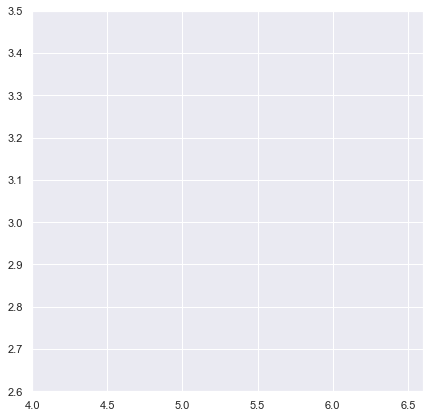

In [51]:
# General settings
fig = plt.figure(figsize=(7,7))
plt.axis([4,6.6,2.6, 3.5,])
camera = Camera(fig)
sns.set()
plt.rcParams['scatter.edgecolors'] = "black"

# Animation
animate_knn(df_plot,10,weight='even')
animation = camera.animate(interval=500,repeat=False)
HTML(animation.to_html5_video())

In [ ]:
# How it should be

# General settings
fig = plt.figure(figsize=(7,7))
plt.axis([4,6.6,2.6, 3.5,])
camera = Camera(fig)
sns.set()
plt.rcParams['scatter.edgecolors'] = "black"

# Parameter grid for loops
weight_list = ['even','proportional']
dataset_list = [df_plot,df_unbal]
metric_list = ['euc_dist','man_dist']
k_list = [5,10,15]

# Animations:
import itertools
for weight, dataset, metric, k in itertools.product(weight_list,dataset_list,metric_list,k_list):
    if dataset.shape[0] == 51:
        df_name = 'balanced'
    else:
        df_name = 'unbalanced'
    print('Creating '+weight+'_'+df_name+'_'+metric+'_'+str(k)+'.mp4')
    animate_knn(dataset,10,weight=weight,metric=metric)
    animation = camera.animate(interval=500,repeat=False)
    HTML(animation.to_html5_video())
    animation.save('AlgoAnimations/'+weight+'_'+df_name+'_'+metric+'_'+str(k)+'.mp4')
    plt.close()    

In [112]:
# How I ended up doing it

# General settings
fig = plt.figure(figsize=(7,7))
plt.axis([4,6.6,2.6, 3.5,])
camera = Camera(fig)
sns.set()
plt.rcParams['scatter.edgecolors'] = "black"

# Animation
df_name = 'unbalanced'
weight = 'even'
metric = 'euclidean'
k = 15
animate_knn(df_unbal,k,weight=weight,metric='euc_dist')
animation = camera.animate(interval=500,repeat=False)
HTML(animation.to_html5_video())
animation.save('AlgoAnimations/'+weight+'_'+df_name+'_'+metric+'_'+str(k)+'.mp4')
plt.close()

## Neighbourhood plotting

Neighborhood plotting for our algorithm. Under construction.

In [122]:
df_mesh = df.drop(columns=['petal_length','petal_width'])
df_mesh = df_mesh.sample(frac=0.2)
df_mesh.shape

(30, 3)

In [114]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

def create_mesh(train,y,k):
    X_train = train.drop(columns=[y]).reset_index(drop=True)
    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
    y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    z_mesh = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # WARNING: Long calculation
    Z = np.array(knn(train,z_mesh,y,k))
    # Encode predictions for plotting
    Z_flat = LabelEncoder().fit_transform(Z.flatten())
    Z_out = np.array(Z_flat)
    return (xx,yy,Z_out)

In [116]:
def plot_mesh(train,y,k,filename):
    X_train = train.drop(columns=[y]).reset_index(drop=True)
    mesh = create_mesh(train,y,k)
    xx,yy,Z_out = mesh[0],mesh[1],mesh[2]
    # Change this
    label = [0,0,1,2,1,2,2,1,0,0,1,0,2,1,0]

    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # Create figure, put the result into a color plot
    plt.figure(figsize=(7,7))
    plt.axis([4,6.6,2.6, 3.5,])
    Z = Z_out.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points

    plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=label, cmap=cmap_bold,edgecolor='k', s=50)
    plt.title("kNN classification: (k=%r)"% k)
    plt.axis('tight')
    plt.savefig(filename+'.png')
    plt.close()

    # Look: c=y, it should be c=label and df_plot encoded in 'species'